# 评估同化算法的性能


In [1]:
%load_ext autoreload
%autoreload 2

## 基本参数设置

In [2]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
plt.style.use(["nature", "no-latex"])
from pathlib import Path
import pickle
import sys 
sys.path.append('../')

Pysteps configuration file found at: /public/home/wangwuxing01/.conda/envs/afnonet-core/lib/python3.8/site-packages/pysteps/pystepsrc



In [3]:
!ls /public/home/wangwuxing01/research/fundation/output

da_cycle  forecast  medium_forecast


In [4]:
da_cycle_dir = "/public/home/wangwuxing01/research/fundation/output_npj/da_cycle"
medium_forecast_dir = "/public/home/wangwuxing01/research/fundation/output_npj/medium_forecast"
scaler_dir = "/public/home/wangwuxing01/research/fundation/data/era5_6_hourly/assim_dir_3day/scaler.pkl"
var_idx_dir = "/public/home/wangwuxing01/research/fundation/data/era5_6_hourly/assim_dir_3day/var_idx.npy"

In [5]:
var_idx = [k for k in np.load(var_idx_dir)]

In [6]:
plot_vars = ["Z", "T", "R", "U"]
unit_y = ["(m$^2$ s$^{-2}$)", "(K)", "(%)", "(m s$^{-1}$)"]
plot_idx = [1, 10, 22, 20, 21, 23, 9, 5, 13, 17]

In [7]:
tmp = xr.open_mfdataset("/public/home/wangwuxing01/research/fundation/data/era5_6_hourly/obs_r_2010.nc", 
                  combine="by_coords", parallel=True)

In [8]:
lat, lon = tmp.latitude.values, tmp.longitude.values

In [9]:
idx = 39

In [10]:
xb = np.load(f"{da_cycle_dir}/xb_3day.npy").astype(np.float32)

xa_dacycle_4dvarnet = np.load(f"{da_cycle_dir}/assim_4dvarnet_obs[8, 9, 10, 11, 20, 21]_xb_3day.npy")[:, 0].astype(np.float32)
xa_dacycle_vit = np.load(f"{da_cycle_dir}/assim_vit_obs[8, 9, 10, 11, 20, 21]_xb_3day.npy")[:, 0].astype(np.float32)
xa_dacycle_4dvarformer = np.load(f"{da_cycle_dir}/assim_4dvarformer_obs[8, 9, 10, 11, 20, 21]_xb_3day.npy")[:, 0].astype(np.float32)

xt = np.load(f"{da_cycle_dir}/real_xb_3day.npy")[:, 0].astype(np.float32)

In [11]:
def compute_mean_spectral_density(data: np.ndarray, timestamp=None, num_times=None):
    num_frequencies = np.max((len(lat), len(lon))) / 2
    mean_spectral_density = np.zeros(int(num_frequencies))
    if num_times is None:
        num_times = int(data.shape[0])

    elif timestamp is not None:
        num_times = 1

    else:
        num_times = num_times
    
    for t in range(num_times):
        tmp = data[t]
        psd, freq = rapsd(tmp, return_freq=True, normalize=True, fft_method=np.fft)
        mean_spectral_density += psd
    mean_spectral_density /= num_times

    return mean_spectral_density, freq

In [12]:
labels = ["Background", "4DVarNet", "ViT", "4DVarFormer", "ERA5 (ground truth)"]
colors = ["g", "b", "y", "r", "k"]
titles = ["50hPa geopotential (m$^2$ s$^{-2}$)", "500hPa geopotential (m$^2$ s$^{-2}$)", "850hPa geopotential (m$^2$ s$^{-2}$)", "1000hPa geopotential (m$^2$ s$^{-2}$)", 
          "50hPa relative humidity (%)", "500hPa relative humidity (%)", "850hPa relative humidity (%)", "1000hPa relative humidity (%)", 
          "50hPa temperature (K)", "500hPa temperature (K)", "850hPa temperature (K)", "1000hPa temperature (K)", 
          "50hPa wind speed (m s$^{-1}$)", "500hPa wind speed (m s$^{-1}$)", "850hPa wind speed (m s$^{-1}$)", "1000hPa wind speed (m s$^{-1}$)", 
           "10-m wind speed (m s$^{-1}$)", "2-m temperature (K)", "mean sea-level pressure (Pa)"]

In [13]:
z50 = [xb[:, 0], xa_dacycle_4dvarnet[:, 0], xa_dacycle_vit[:, 0], xa_dacycle_4dvarformer[:, 0], xt[:, 0]]
z500 = [xb[:, 1], xa_dacycle_4dvarnet[:, 1], xa_dacycle_vit[:, 1], xa_dacycle_4dvarformer[:, 1], xt[:, 1]]
z850 = [xb[:, 2], xa_dacycle_4dvarnet[:, 2], xa_dacycle_vit[:, 2], xa_dacycle_4dvarformer[:, 2], xt[:, 2]]
z1000 = [xb[:, 3], xa_dacycle_4dvarnet[:, 3], xa_dacycle_vit[:, 3], xa_dacycle_4dvarformer[:, 3], xt[:, 3]]

r50 = [xb[:, 4], xa_dacycle_4dvarnet[:, 4], xa_dacycle_vit[:, 4], xa_dacycle_4dvarformer[:, 4], xt[:, 4]]
r500 = [xb[:, 5], xa_dacycle_4dvarnet[:, 5], xa_dacycle_vit[:, 5], xa_dacycle_4dvarformer[:, 5], xt[:, 5]]
r850 = [xb[:, 6], xa_dacycle_4dvarnet[:, 6], xa_dacycle_vit[:, 6], xa_dacycle_4dvarformer[:, 6], xt[:, 6]]
r1000 = [xb[:, 7], xa_dacycle_4dvarnet[:, 7], xa_dacycle_vit[:, 7], xa_dacycle_4dvarformer[:, 7], xt[:, 7]]

t50 = [xb[:, 8], xa_dacycle_4dvarnet[:, 8], xa_dacycle_vit[:, 8], xa_dacycle_4dvarformer[:, 8], xt[:, 8]]
t500 = [xb[:, 9], xa_dacycle_4dvarnet[:, 9], xa_dacycle_vit[:, 9], xa_dacycle_4dvarformer[:, 9], xt[:, 9]]
t850 = [xb[:, 10], xa_dacycle_4dvarnet[:, 10], xa_dacycle_vit[:, 10], xa_dacycle_4dvarformer[:, 10], xt[:, 10]]
t1000 = [xb[:, 11], xa_dacycle_4dvarnet[:, 11], xa_dacycle_vit[:, 11], xa_dacycle_4dvarformer[:, 11], xt[:, 11]]

u50 = [xb[:, 12], xa_dacycle_4dvarnet[:, 12], xa_dacycle_vit[:, 12], xa_dacycle_4dvarformer[:, 12], xt[:, 12]]
u500 = [xb[:, 13], xa_dacycle_4dvarnet[:, 13], xa_dacycle_vit[:, 13], xa_dacycle_4dvarformer[:, 13], xt[:, 13]]
u850 = [xb[:, 14], xa_dacycle_4dvarnet[:, 14], xa_dacycle_vit[:, 14], xa_dacycle_4dvarformer[:, 14], xt[:, 14]]
u1000 = [xb[:, 15], xa_dacycle_4dvarnet[:, 15], xa_dacycle_vit[:, 15], xa_dacycle_4dvarformer[:, 15], xt[:, 15]]
u10 = [xb[:, 20], xa_dacycle_4dvarnet[:, 20], xa_dacycle_vit[:, 20], xa_dacycle_4dvarformer[:, 20], xt[:, 20]]

v50 = [xb[:, 16], xa_dacycle_4dvarnet[:, 16], xa_dacycle_vit[:, 16], xa_dacycle_4dvarformer[:, 16], xt[:, 16]]
v500 = [xb[:, 17], xa_dacycle_4dvarnet[:, 17], xa_dacycle_vit[:, 17], xa_dacycle_4dvarformer[:, 17], xt[:, 17]]
v850 = [xb[:, 18], xa_dacycle_4dvarnet[:, 18], xa_dacycle_vit[:, 18], xa_dacycle_4dvarformer[:, 18], xt[:, 18]]
v1000 = [xb[:, 19], xa_dacycle_4dvarnet[:, 19], xa_dacycle_vit[:, 19], xa_dacycle_4dvarformer[:, 19], xt[:, 19]]
v10 = [xb[:, 21], xa_dacycle_4dvarnet[:, 21], xa_dacycle_vit[:, 21], xa_dacycle_4dvarformer[:, 21], xt[:, 21]]

wsp50 = [np.sqrt(u50[i]**2+v50[i]**2) for i in range(len(u50))]
wsp500 = [np.sqrt(u500[i]**2+v500[i]**2) for i in range(len(u500))]
wsp850 = [np.sqrt(u850[i]**2+v850[i]**2) for i in range(len(u850))]
wsp1000 = [np.sqrt(u1000[i]**2+v1000[i]**2) for i in range(len(u1000))]
wsp10 = [np.sqrt(u10[i]**2+v10[i]**2) for i in range(len(u10))]

t2m = [xb[:, 22], xa_dacycle_4dvarnet[:, 22], xa_dacycle_vit[:, 22], xa_dacycle_4dvarformer[:, 22], xt[:, 22]]
msl = [xb[:, 23], xa_dacycle_4dvarnet[:, 23], xa_dacycle_vit[:, 23], xa_dacycle_4dvarformer[:, 23], xt[:, 23]]

vis = [z50, z500, z850, z1000,
      r50, r500, r850, r1000,
      t50, t500, t850, t1000,
      wsp50, wsp500, wsp850, wsp1000,
      wsp10, t2m, msl]

In [14]:
psds, freqs = [], []
for i in range(len(vis)):
    psds_v, freqs_v = [], []
    for j in range(len(z500)):
        psd, freq = compute_mean_spectral_density(vis[i][j])
        psds_v.append(psd)
        freqs_v.append(freq)
    psds.append(psds_v)
    freqs.append(freq)

In [15]:
print(psds[0][0].shape)

(80,)


In [16]:
def subplot_psd(psds, freqs, labels, titles, colors, axis=None, fname=None):
    fig, axes = plt.subplots(5, 4, figsize=(15, 18))
    for i in range(5):
        for j in range(4):
            x_vals = 1 / freqs[i] * 0.25 * 111 / 2
            if i*4+j < 19:
                axes[i, j].set_title(titles[i*4+j], fontsize=12)
            for k in range(len(psds[0])):
                if i*4+j < 19:
                    if k in [0, 3, 4]:
                        axes[i,j].plot(x_vals, psds[i*4+j][k], label=labels[k], color=colors[k], linewidth=2)
                    else:
                        axes[i,j].plot(x_vals, psds[i*4+j][k], label=labels[k])
                    # axes[i,j].legend(loc='lower left', fontsize=12)
                    axes[i,j].set_xlim(x_vals[1], x_vals[-1]-5)
                    axes[i,j].set_yscale('log', base=10)
                    axes[i,j].set_xscale('log', base=2)
                    axes[i,j].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
                    axes[i,j].grid()
                    axes[i,j].tick_params(axis="x", labelsize=12)
                    axes[i,j].tick_params(axis="y", labelsize=12)
                    axes[i,j].set_xlabel(r'WaveLength [km]', fontsize=12)
                    axes[i,j].set_ylabel('PSD [a.u]', fontsize=12)
    fig.delaxes(axes[-1][-1])
    lines, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(lines, labels, ncol=5, loc='lower center', bbox_to_anchor=(0.5, 0), fontsize=12)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.06)
    plt.savefig("PSD.jpg", format='jpg', dpi=300, bbox_inches='tight')
    plt.savefig("PSD.pdf", format='pdf', dpi=300, bbox_inches='tight')

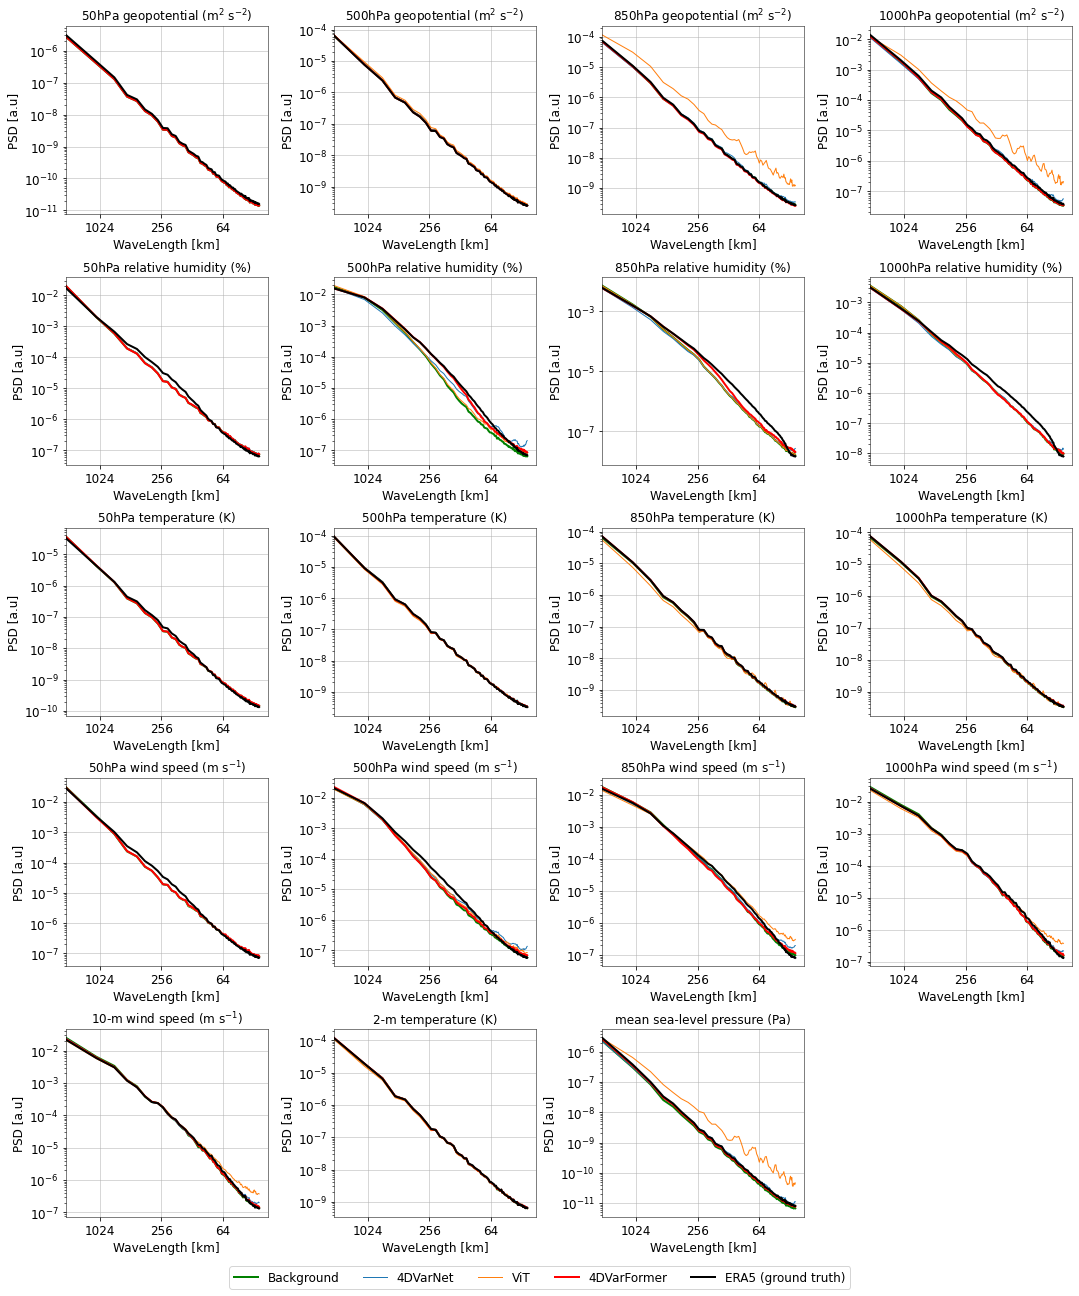

In [17]:
subplot_psd(psds, freqs, labels, titles, colors)